Number of PCs needed
Image 1 and 16 account for the following proportion of the variance
[0.30731765 0.00744774]


ValueError: shapes (1,) and (3744,) not aligned: 1 (dim 0) != 3744 (dim 0)

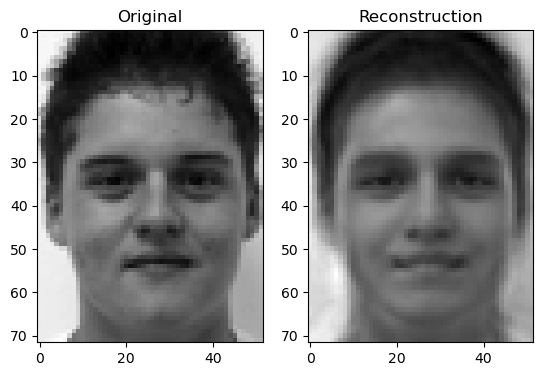

<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load data
smile_intensity = np.loadtxt('../Data/smile_intensity.txt')
images = np.loadtxt('../Data/images.txt')
image_data = images
mean_image_data = np.mean(image_data, axis=0)
image_data_zeromean = image_data - mean_image_data
image_files_numrows = 72
image_files_numcols = 52

# Q4.1 Use PCA to find the number of PCs needed to keep 90% of the variance
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(image_data_zeromean)
cumulated_variance = np.cumsum(pca.explained_variance_ratio_)

print('Number of PCs needed')
Npc = np.min(np.where(cumulated_variance > 0.9))

recon_image_indx = 23
image_data_recon = np.dot(pca.transform(image_data_zeromean[recon_image_indx, :].reshape(1, -1))[:, :Npc], pca.components_[:Npc, :]) + mean_image_data

# Display the images
image = image_data[recon_image_indx, :].reshape(image_files_numrows, image_files_numcols)
image_recon = image_data_recon.reshape(image_files_numrows, image_files_numcols)

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(image_recon, cmap='gray')
plt.title('Reconstruction')

# Q4.2
pc_indx = [0, 15]  # these are the two PCs we are interested in
print('Image 1 and 16 account for the following proportion of the variance')
print(pca.explained_variance_ratio_[pc_indx])

# Q4.3 Visualize min - max face for pc1 / pc 16
for p in pc_indx:
    min_idx = np.argmin(pca.transform(image_data_zeromean)[:, p])
    max_idx = np.argmax(pca.transform(image_data_zeromean)[:, p])

    plt.figure()
    for i, idx in enumerate([min_idx, max_idx]):
        image_data_recon = np.dot(pca.transform(image_data_zeromean[idx, :].reshape(1, -1))[:, p], pca.components_[p, :]) + mean_image_data

        image_recon = image_data_recon.reshape(image_files_numrows, image_files_numcols)
        plt.subplot(1, 2, i + 1)
        plt.imshow(image_recon, cmap='gray')
        plt.title(f'PC {p}')

# Q4.4 Calculate the covariance between the smile intensity and PC 1 and 16
PcSmileCov = np.zeros(55)

for n in range(55):
    cov_matrix = np.cov(pca.transform(image_data_zeromean)[:, n], smile_intensity)
    PcSmileCov[n] = cov_matrix[0, 1]

print('Image 1 and 16 covariance with smile score')
print(PcSmileCov[pc_indx])

# Q4.6 10 PCs with numerically greatest covariance with the smile score
I_covpc = np.argsort(np.abs(PcSmileCov))[::-1]
print('Three PCs with the highest covariance with the smile intensity')
predictor_names = I_covpc[:3]

# Q4.6-7 Fit linear model and synthesize images
predictor_names = np.arange(3)  # the competing model uses PC 1, 2, and 3 as predictors

for s in range(2):
    plt.figure(figsize=(12, 6))
    model_data = pca.transform(image_data_zeromean)[:, predictor_names]
    linear_model = LinearRegression().fit(model_data, smile_intensity)
    model_coefficients = linear_model.coef_

    # generate faces
    synth_smile_intensities = np.arange(-0.5, 1.6, 0.5)

    for i, target_smile_intensity in enumerate(synth_smile_intensities):
        alpha = (target_smile_intensity - model_coefficients[0]) / np.sum(model_coefficients[1:]**2)
        target_scores = alpha * model_coefficients[1:]

        target_image_data = np.dot(pca.components_[predictor_names, :].T, target_scores) + mean_image_data

        plt.subplot(1, len(synth_smile_intensities), i + 1)

        image_synth = target_image_data.reshape(image_files_numrows, image_files_numcols)
        plt.imshow(image_synth, cmap='gray')
        plt.title(f'Score {target_smile_intensity:.1f}')

plt.show()
